In [2]:
# !pip install -q transformers datasets git+https://github.com/huggingface/peft sentencepiece accelerate
# !pip install -q peft transformers datasets


In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, default_data_collator, get_linear_schedule_with_warmup
from peft import get_peft_config, get_peft_model, get_peft_model_state_dict, PrefixTuningConfig, TaskType
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
import os
from datasets import Dataset
import torch
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

2023-09-26 22:45:50.051463: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-26 22:45:50.128124: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-26 22:45:50.129732: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 22:45:51.065021: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
cuda_id = ':0'
device = torch.device(f"cuda{cuda_id}" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [3]:
model_name_or_path = "google/flan-t5-large"
tokenizer_name_or_path = "google/flan-t5-large"

text_column = "description"
label_column = "target"
max_length = 128
lr = 1e-2
num_epochs = 5
batch_size = 8

## Loading and preparing the dataset

In [4]:
file_path = "/local/nursulu/bert_and_friends/coca_nouns_by_chat_gpt_5340.csv"

In [5]:
dataset_name = "targets_descriptions"

text_column = "description"
label_column = "target"
df = pd.read_csv(file_path)
df = df[:1000]

print(f"Number of descriptions: {len(df)}")
print(f"Number of target words: {df['target'].nunique()}")

df.head()

Number of descriptions: 1000
Number of target words: 1000


,target,description,type
0,principal,"The main or primary person, thing, or concept ...",NaN
1,percentage,It's the way we show parts of something in re...,NaN
2,survey,A method of collecting information or opinions...,NaN
3,set,"A collection of distinct objects, considered a...",NaN
4,day,"A period of approximately 24 hours, marked by ...",NaN


In [17]:
# Create Transformers dataset
data = {"target": [word for word in df['target']], "description":[descr for descr in df['description']]}
dataset = Dataset.from_dict(data)
dataset_split = dataset.train_test_split(test_size=0.2, shuffle=True, seed=42)
dataset_split['train'][0]

targets = dataset_split['train']['target']
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id
target_max_length = max([len(tokenizer(target)["input_ids"]) for target in targets])
print(target_max_length)

7


In [19]:
dev_test = dataset_split["test"].train_test_split(test_size=0.5, shuffle=True, seed=42)
dataset_split["validation"] = dev_test['train']
dataset_split["test"] = dev_test['test']

In [20]:
dataset_split

DatasetDict({
    train: Dataset({
        features: ['target', 'description'],
        num_rows: 800
    })
    test: Dataset({
        features: ['target', 'description'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['target', 'description'],
        num_rows: 100
    })
})

In [21]:
#preprocess dataset
#Initializing a tokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)

In [22]:
#Preprocessing inputs function

def preprocess_function(examples):
    inputs = examples[text_column]
    targets = examples[label_column]
    prefix = "Description: "
    suffix = " Word: "
    inputs = [prefix + input_text + suffix for input_text in inputs]

    model_inputs = tokenizer(inputs, max_length=max_length, padding="max_length", truncation=True, return_tensors="pt")
    labels = tokenizer(targets, padding="max_length", truncation=True, return_tensors="pt")
    labels = labels["input_ids"]
    labels[labels == tokenizer.pad_token_id] = -100
    model_inputs["labels"] = labels
    return model_inputs

In [23]:
processed_datasets = dataset_split.map(
    preprocess_function,
    batched=True,
    num_proc=1,
    remove_columns=dataset_split["train"].column_names,
    load_from_cache_file=False,
    desc="Running tokenizer on dataset",
)

Running tokenizer on dataset:   0%|          | 0/800 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

In [24]:
processed_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 800
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
})

In [25]:
train_dataset = processed_datasets["train"]
eval_dataset = processed_datasets["validation"]

train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True
)
eval_dataloader = DataLoader(eval_dataset, collate_fn=default_data_collator, batch_size=batch_size, pin_memory=True)

In [26]:
for i in range(10):
    print(tokenizer.decode(train_dataset['input_ids'][i], skip_special_tokens=True))

Description: The greatest or smallest amount or extent of something. Word: 
Description: It is a season of the year that comes after spring and before autumn. Word: 
Description: It is similar to type or category. Word: 
Description: The opposite of work. Word: 
Description: A container made of fabric or material used for carrying things. Word: 
Description: An area of land or a large quantity or number of something. Word: 
Description: It is a synonym of job. Word: 
Description: Something that is known to be true because it can be proven or verified, without personal opinions or interpretations involved. Word: 
Description: A person who belongs to a political group that often supports progressive policies. Word: 
Description: It is the opposite for wife. Word: 


## Model configuration

In [27]:
peft_config = PrefixTuningConfig(task_type=TaskType.SEQ_2_SEQ_LM, inference_mode=False, num_virtual_tokens=20)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name_or_path)
model = get_peft_model(model, peft_config)

In [28]:
model.print_trainable_parameters()
"trainable params: 983040 || all params: 738651136 || trainable%: 0.13308583065659835"

trainable params: 983,040 || all params: 784,133,120 || trainable%: 0.1253664683874085


'trainable params: 983040 || all params: 738651136 || trainable%: 0.13308583065659835'

In [29]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

## Training

In [30]:
model = model.to(device)

for epoch in range(num_epochs):
    print(f"-----Epoch {epoch} has started-----")
    model.train()
    total_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.detach().float()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    model.eval()
    eval_loss = 0
    eval_preds = []
    for step, batch in enumerate(tqdm(eval_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        eval_loss += loss.detach().float()
        eval_preds.extend(
            tokenizer.batch_decode(torch.argmax(outputs.logits, -1).detach().cpu().numpy(), skip_special_tokens=True)
        )

    eval_epoch_loss = eval_loss / len(eval_dataloader)
    eval_ppl = torch.exp(eval_epoch_loss)
    train_epoch_loss = total_loss / len(train_dataloader)
    train_ppl = torch.exp(train_epoch_loss)
    print(f"{epoch=}: {train_ppl=} {train_epoch_loss=} {eval_ppl=} {eval_epoch_loss=}")

-----Epoch 0 has started-----


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:52<00:00,  4.05s/it]


epoch=0: train_ppl=tensor(4.4415) train_epoch_loss=tensor(1.4910) eval_ppl=tensor(3.3954) eval_epoch_loss=tensor(1.2224)
-----Epoch 1 has started-----


100%|██████████| 13/13 [00:52<00:00,  4.00s/it]


epoch=1: train_ppl=tensor(3.0770) train_epoch_loss=tensor(1.1240) eval_ppl=tensor(3.1862) eval_epoch_loss=tensor(1.1588)
-----Epoch 2 has started-----


100%|██████████| 13/13 [00:54<00:00,  4.23s/it]


epoch=2: train_ppl=tensor(2.6957) train_epoch_loss=tensor(0.9917) eval_ppl=tensor(3.2231) eval_epoch_loss=tensor(1.1704)
-----Epoch 3 has started-----


100%|██████████| 13/13 [00:49<00:00,  3.79s/it]


epoch=3: train_ppl=tensor(2.5628) train_epoch_loss=tensor(0.9411) eval_ppl=tensor(3.1826) eval_epoch_loss=tensor(1.1577)
-----Epoch 4 has started-----


100%|██████████| 13/13 [00:49<00:00,  3.84s/it]

epoch=4: train_ppl=tensor(2.4975) train_epoch_loss=tensor(0.9153) eval_ppl=tensor(3.2031) eval_epoch_loss=tensor(1.1641)


## Validation

In [31]:
correct = 0
total = 0
for pred, true in zip(eval_preds, dataset_split["validation"]["target"]):
    if pred.strip() == true.strip():
        correct += 1
    total += 1
accuracy = correct / total * 100
print(f"{accuracy=} % on the validation dataset")

accuracy=1.0 % on the validation dataset


In [32]:
# for i in range(len(dataset_split['validation']['description'])):
#     print(dataset_split['validation']['description'][i])
#     print("prediction:", eval_preds[i], "target:", dataset_split['validation']['target'][i])

Killing of a person.
prediction: murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder                                murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder murder                                                                                   

## Test set

In [35]:
def count_top_k_predictions(dataset, k=10, model=model):
    '''
    Count top-K predictions for each word + probabilities of these predictions
    '''
    
    descriptions = dataset['test']['description']
    targets = dataset['test']['target']

    inputs = [f"Descripton : {x}. Word : " for x in descriptions]

    inputs = tokenizer(
        inputs,
        padding=True, truncation=True,
        return_tensors="pt",
    )

    model.to(device)
    
    with torch.no_grad():
        inputs = {k: v.to(device) for k, v in inputs.items()}
        output_sequences = model.generate(input_ids=inputs["input_ids"], max_new_tokens=10, num_beams=k, num_return_sequences=k, #max_length=3,
                                                    top_p = 50, output_scores=True, return_dict_in_generate=True) #repetition_penalty=10000.0
        #print("output_sequences", output_sequences)
        logits = torch.tensor(output_sequences['sequences_scores'])
        decoded_probabilities = torch.softmax(logits, dim=0)
        
        words_vs_probs = defaultdict()
        
        #all word predictions
        final_list = []
        for i in range(0, len(output_sequences['sequences']), k):
            sublist = output_sequences['sequences'][i:i + k]
            final_list.append(sublist)
        
        #all prediction probabilities
        final_probs = []
        for i in range(0, len(decoded_probabilities), k):
            sublist = decoded_probabilities[i:i + k]
            final_probs.append(sublist)
            
        predict_test = []
        
        for i in tqdm(range(len(targets))):
            words_vs_probs[(descriptions[i], targets[i])] = {}
            #print(sentences[i])
            preds = []
            for j in range(k):
                #print("Prediction number", j)
                predicted_token_ids = final_list[i][j]
                decoded_predictions = tokenizer.decode(predicted_token_ids, skip_special_tokens=True)
                words_vs_probs[(descriptions[i], targets[i])][decoded_predictions] = round(float(final_probs[i][j]*100), 2)
                preds.append(decoded_predictions)
            predict_test.append(preds)
    
    return [predict_test, words_vs_probs]

In [ ]:
def count_accuracy(pred, true, top_k=10):
  '''
  This function evaluates performance of the t5 family models on top-k candidates.
  '''
  accuracy = []
  rank_vs_accuracy = dict()
  for i in range(len(pred)): 
    ground_truth = true[i].strip().lower()
    #print("ground_truth:", ground_truth)
    preds = pred[i]
    #print("preds", preds)
    accuracy_sent = [1 if any(pred.strip().lower() == ground_truth for pred in preds[:top_k]) else 0]
    #print("accuracy_sent", accuracy_sent)
    accuracy.extend(accuracy_sent)
    rank_vs_accuracy[coca_words.index(ground_truth)] = accuracy_sent

  accuracy = sum(accuracy)
  accuracy /= len(pred)
  return [accuracy, rank_vs_accuracy]

### Counting accuracy on top-K, test set

In [42]:
coca_words = list(df['target'])
true = dataset_split['test']["target"]

In [43]:
predict_test, words_vs_probs = count_top_k_predictions(dataset_split, k=10)

/tmp/ipykernel_17862/3069501002.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = torch.tensor(output_sequences['sequences_scores'])
100%|██████████| 100/100 [00:00<00:00, 4928.39it/s]


In [44]:
for key in words_vs_probs:
    print(key)
    print(words_vs_probs[key])

('It is similar to the beast or creature.', 'being')
{'animal': 0.3, 'monster': 0.15, 'creature': 0.13, 'bird': 0.09, 'dog': 0.05, 'human': 0.05, 'cat': 0.05, 'snake': 0.04, 'spider': 0.03, 'beast': 0.03}
('It is similar to concentration.', 'focus')
{'focus': 0.24, 'effort': 0.18, 'concentraiton': 0.15, 'concentraion': 0.12, 'drowsiness': 0.11, 'receptivity': 0.09, 'concentrism': 0.09, 'concentration': 0.09, 'arousal': 0.09, 'dilution': 0.09}
('It is similar to area, neighborhood, or region.', 'district')
{'city': 0.24, 'district': 0.17, 'town': 0.12, 'area': 0.11, 'region': 0.1, 'neighborhood': 0.08, 'zone': 0.07, 'state': 0.06, 'territory': 0.05, 'community': 0.05}
('It is a synonym for trauma or damage.', 'injury')
{'injury': 0.35, 'attack': 0.09, 'accident': 0.08, 'wound': 0.06, 'harm': 0.06, 'damage': 0.05, 'assault': 0.04, 'trauma': 0.04, 'hurt': 0.04, 'hurtness': 0.03}
('Wet stuff that keeps us from being thirsty.', 'water')
{'drink': 0.29, 'water': 0.24, 'hydration': 0.07, 'bee

In [45]:
accuracy_100 = dict()
rank_vs_accuracy_100 = dict()
for i in range(1, 11):
  acc_100 = count_accuracy(predict_test, true, top_k=i)
  accuracy_100[i] = acc_100[0]
  rank_vs_accuracy_100[i] = acc_100[1]

In [46]:
accuracy_100

{1: 0.5,
 2: 0.65,
 3: 0.72,
 4: 0.76,
 5: 0.78,
 6: 0.83,
 7: 0.83,
 8: 0.84,
 9: 0.85,
 10: 0.87}

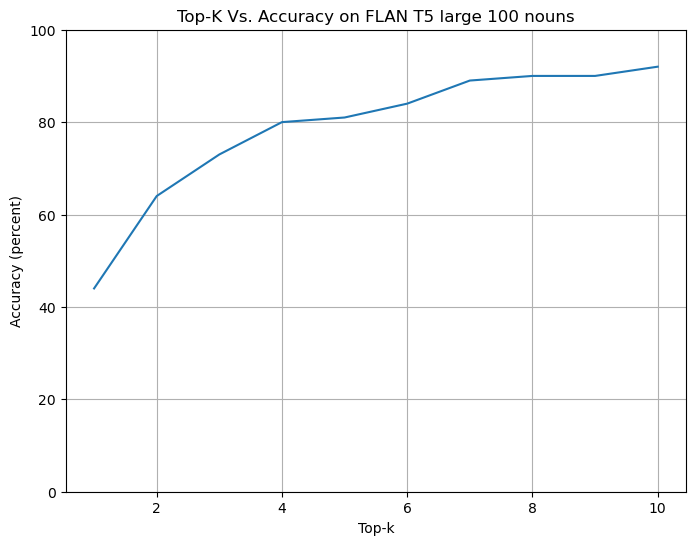

In [59]:
x = accuracy_100.keys()
y = [val * 100 for val in accuracy_100.values()]
plt.figure(figsize=(8, 6))  # Increase figure size
plt.plot(x, y)
plt.ylim(0, 100)
plt.grid(True)  # Add grid lines
plt.xlabel("Top-k")
plt.ylabel("Accuracy (percent)")
plt.title(f"Top-K Vs. Accuracy on {model_name_or_path} 100 nouns top-10")
plt.savefig(f'/local/nursulu/bert_and_friends/results/top_10_accuracy_{model_name_or_path}_100_nouns_5_epochs.png')
plt.show()

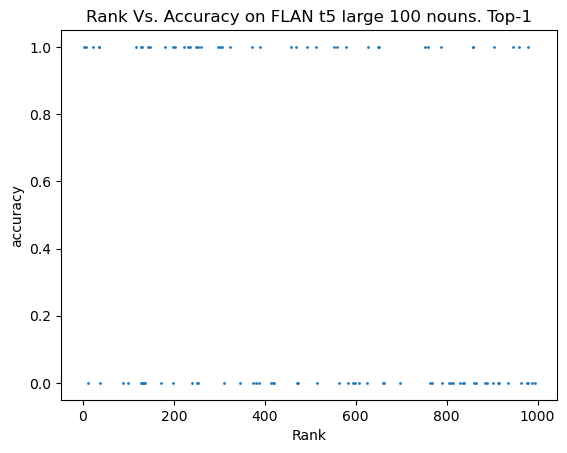

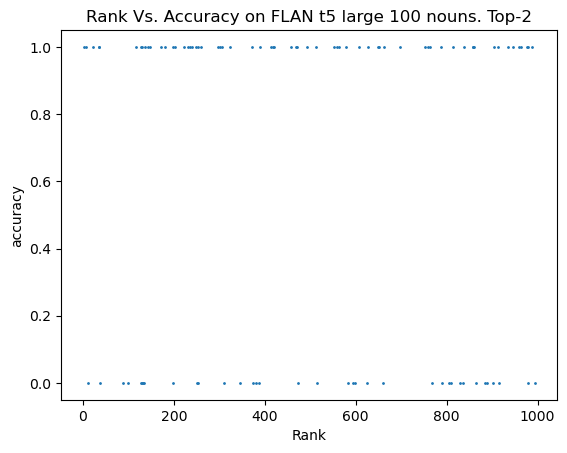

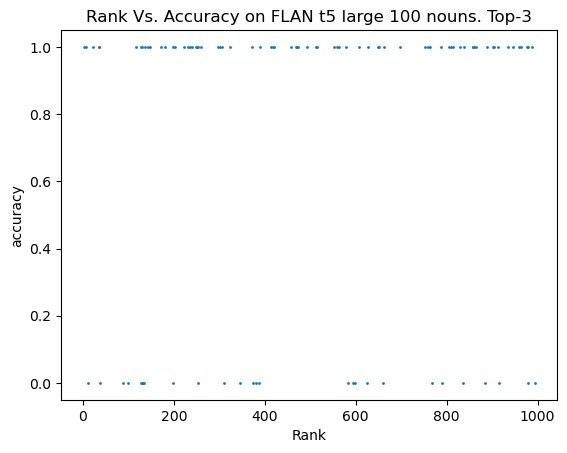

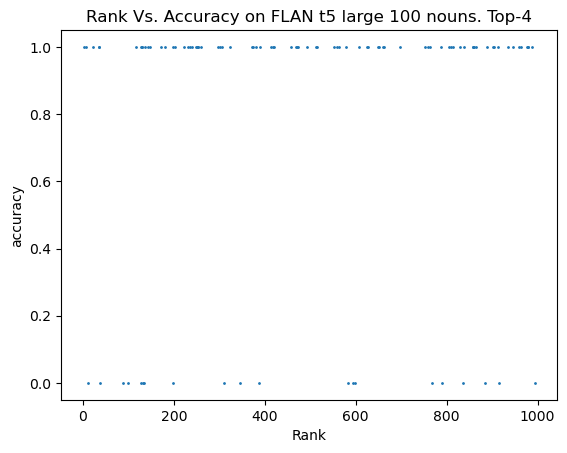

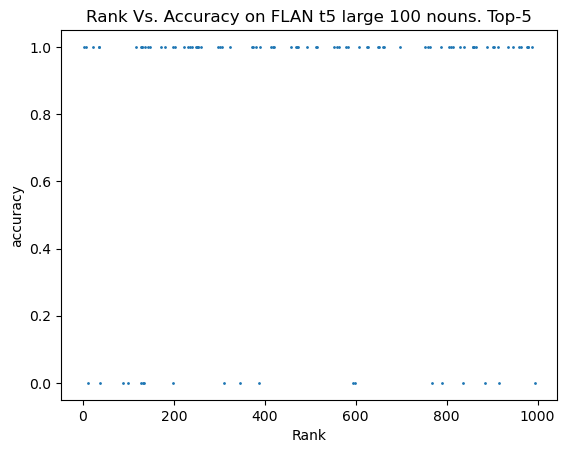

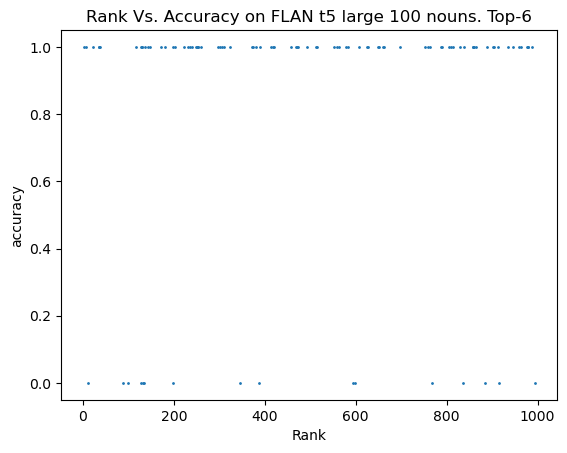

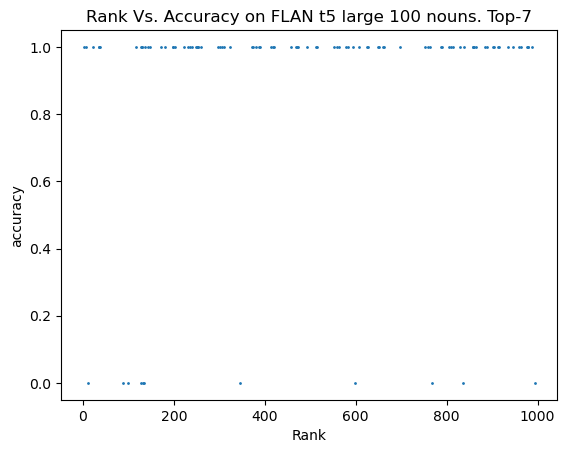

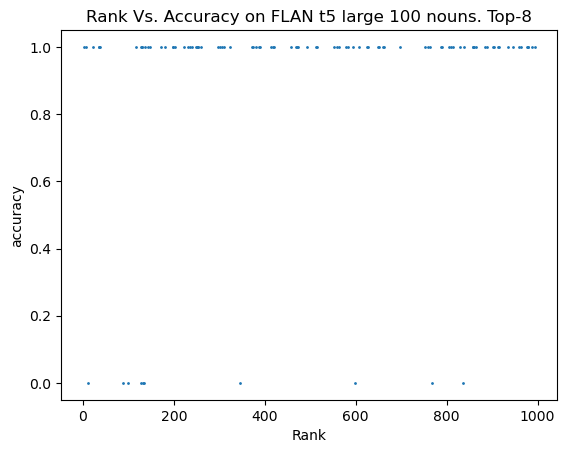

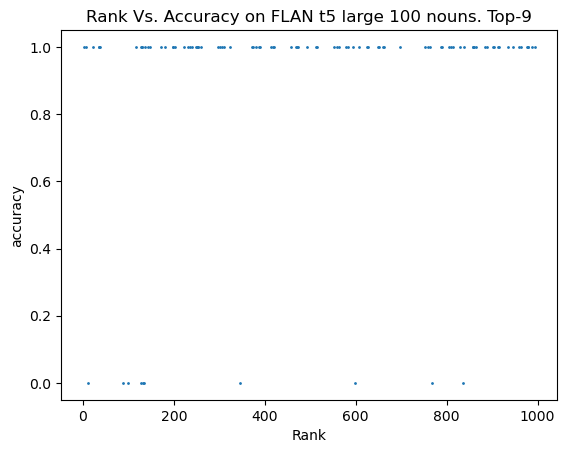

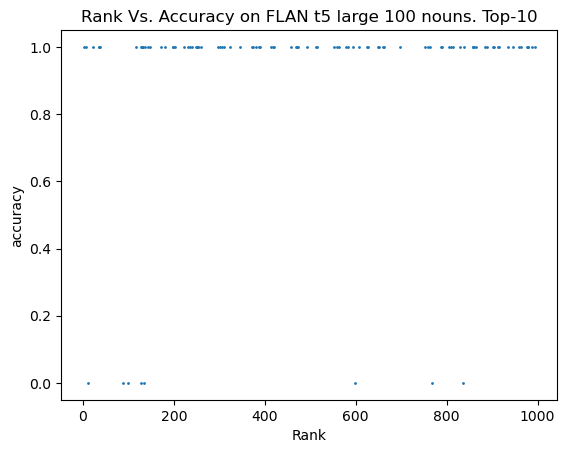

In [58]:
for i in range(1, 11):
  x = rank_vs_accuracy_100[i].keys()
  y = rank_vs_accuracy_100[i].values()

  plt.scatter(x, y, s=1)
  plt.xlabel("Rank")
  plt.ylabel("accuracy")
  plt.title(f"Rank Vs. Accuracy on {model_name_or_path} 100 nouns. Top-{i}")
  plt.savefig(f'/local/nursulu/bert_and_friends/results/rank_vs_accuracy_{model_name_or_path}_top_{i}.png')
  plt.show()

## Testing zero-shot behavior

In [62]:
base_model = AutoModelForSeq2SeqLM.from_pretrained(model_name_or_path)

In [64]:
predict_test_zero, words_vs_probs_zero = count_top_k_predictions(dataset_split, k=10, model=base_model)

/tmp/ipykernel_22695/297033060.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = torch.tensor(output_sequences['sequences_scores'])
100%|██████████| 100/100 [00:00<00:00, 4714.66it/s]


In [1]:
# for key in words_vs_probs_zero:
#     print(key)
#     print(words_vs_probs_zero[key])

In [67]:
accuracy_100_zero = dict()
rank_vs_accuracy_100_zero = dict()
for i in range(1, 11):
  acc_100 = count_accuracy(predict_test_zero, true, top_k=i)
  accuracy_100_zero[i] = acc_100[0]
  rank_vs_accuracy_100_zero[i] = acc_100[1]

In [69]:
accuracy_100_zero

{1: 0.2,
 2: 0.26,
 3: 0.28,
 4: 0.32,
 5: 0.34,
 6: 0.36,
 7: 0.36,
 8: 0.39,
 9: 0.39,
 10: 0.39}

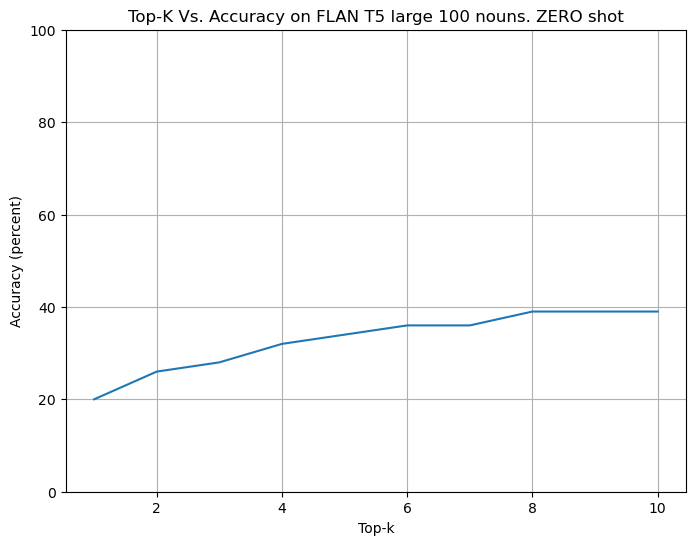

In [68]:
x = accuracy_100_zero.keys()
y = [val * 100 for val in accuracy_100_zero.values()]
plt.figure(figsize=(8, 6))  # Increase figure size
plt.plot(x, y)
plt.ylim(0, 100)
plt.grid(True)  # Add grid lines
plt.xlabel("Top-k")
plt.ylabel("Accuracy (percent)")
plt.title(f"Top-K Vs. Accuracy on {model_name_or_path} 100 nouns top 10. ZERO shot")
plt.savefig(f'/local/nursulu/bert_and_friends/results/top_10_accuracy_{model_name_or_path}_100_nouns_zero_shot.png')
plt.show()

## Saving the model

In [76]:
from huggingface_hub import notebook_login

notebook_login()

In [78]:
peft_model_id = "YouNameIt/T5ForReverseDictionary_prefix_tuned"
model.push_to_hub(peft_model_id, use_auth_token=True, create_pr=1)

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.bin:   0%|          | 0.00/3.93M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/YouNameIt/T5ForReverseDictionary_prefix_tuned/commit/1dffcfa90c9d97f19b2f6dc4b4d4483ee53877d1', commit_message='Upload model', commit_description='', oid='1dffcfa90c9d97f19b2f6dc4b4d4483ee53877d1', pr_url='https://huggingface.co/YouNameIt/T5ForReverseDictionary_prefix_tuned/discussions/1', pr_revision='refs/pr/1', pr_num=1)

## Load the model from HuggingFace

In [55]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSeq2SeqLM

config = PeftConfig.from_pretrained("NursNurs/T5ForReverseDictionary")
my_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-large")
my_model = PeftModel.from_pretrained(my_model, "NursNurs/T5ForReverseDictionary")

In [60]:
my_sents = ['Something you have on your hands', "You do it when you need to get immunity from some disease", "A yellow sweet fruit"]
inputs = [f"Descripton : {x}. Word : " for x in my_sents]

inputs = tokenizer(
    inputs,
    padding=True, truncation=True,
    return_tensors="pt",
)


my_model.to(device)

with torch.no_grad():
    inputs = {k: v.to(device) for k, v in inputs.items()}

    outputs = model.generate(input_ids=inputs["input_ids"], max_new_tokens=128)
    predict_test = tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)
    print(tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True))

## Test on ChatGPT generated test set

In [ ]:
file_path_test = "100_gpt_regular.csv"

In [ ]:
test = pd.read_csv(file_path_test)

In [ ]:
test = {
    'description': test['Descriptions'],
    'target': test['Word']
}

In [ ]:
sentences = test['description']

inputs = [f"Descripton : {x}. Word : " for x in sentences]

inputs = tokenizer(
    inputs,
    padding=True, truncation=True,
    return_tensors="pt",
)

In [ ]:
model.to(device)
#specify top K outputs to be regarded
k = 5

with torch.no_grad():
    inputs = {k: v.to(device) for k, v in inputs.items()}
    output_sequences = model.generate(input_ids=inputs["input_ids"], max_new_tokens=10, num_beams=k, num_return_sequences=k, #max_length=3,
                                                top_p = 50, output_scores=True, return_dict_in_generate=True) #repetition_penalty=10000.0
    #print("output_sequences", output_sequences)
    logits = torch.tensor(output_sequences['sequences_scores'])
    decoded_probabilities = torch.softmax(logits, dim=0)
    
    final_list = []
    for i in range(0, len(output_sequences['sequences']), 5):
        sublist = output_sequences['sequences'][i:i + 5]
        final_list.append(sublist)
        
    final_probs = []
    for i in range(0, len(decoded_probabilities), 5):
        sublist = decoded_probabilities[i:i + 5]
        final_probs.append(sublist)
        
    predict_test = []
      
    for i in range(100):
        # print(sentences[i])
        preds = []
        for j in range(k):
            #print("Prediction number", j)
            predicted_token_ids = final_list[i][j]
            decoded_predictions = tokenizer.decode(predicted_token_ids, skip_special_tokens=True)
            #print(decoded_predictions, "-", round(float(final_probs[i][j]*100), 2), "%")
            preds.append(decoded_predictions)
        predict_test.append(preds)

A large, flightless bird with a long neck and legs, native to Australia.
Prediction number 0
bird - 0.41 %
Prediction number 1
 - 0.34 %
Prediction number 2
goose - 0.13 %
Prediction number 3
par - 0.09 %
Prediction number 4
bat - 0.08 %
A handheld device used for calculating and performing mathematical operations.
Prediction number 0
calculator - 0.59 %
Prediction number 1
computer - 0.05 %
Prediction number 2
tablet - 0.01 %
Prediction number 3
calculator  - 0.01 %
Prediction number 4
calculators - 0.01 %
A cylindrical object made of glass or plastic, used for storing and drinking beverages.
Prediction number 0
glass - 0.36 %
Prediction number 1
cup - 0.34 %
Prediction number 2
bottle - 0.23 %
Prediction number 3
drink - 0.14 %
Prediction number 4
 - 0.08 %
A small, winged insect known for its ability to produce a high-pitched buzzing sound.
Prediction number 0
bug - 0.28 %
Prediction number 1
fly - 0.2 %
Prediction number 2
 - 0.2 %
Prediction number 3
insect - 0.18 %
Prediction num

/tmp/ipykernel_2163/2152795522.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = torch.tensor(output_sequences['sequences_scores'])
